# Probabilistic Principal Component Analysis (PPCA)

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.linalg import eigh, inv
from sklearn.datasets import load_iris

In [2]:
%config InlineBackend.figure_format = "retina"
np.set_printoptions(precision=4, suppress=True)

* <span style="color:crimson">PPCA correctly captures the variance of the data along the principal axes, and approximates the varianace in all remaining directions with a single average value $\sigma^2$</span>

* PPCA is principal component analysis as the Maximum Likelihood solution of a probabilistic latent variable model

* In PPCA, we map from latent space to data space using

$$
    {\bf x}\vert{\bf z} = W{\bf z} + {\boldsymbol\mu} + \boldsymbol\epsilon
$$

Where

1. ${\bf z}$ is a latent variable that models the <span style="color:crimson">principal-component subspace</span>.
2. ${\bf x}$ is the observed variable 
3. $\boldsymbol\epsilon \sim \mathcal{N}\left({\bf 0}, \sigma^2{\bf I}\right)$

and we assume 

$$
    p({\bf z}) = \mathcal{N}\left(z\vert{\bf 0}, {\bf I}\right)
$$

$$
    p({\bf x} \vert {\bf z}) = \mathcal{N}\left({\bf x} \vert W{\bf z} + {\boldsymbol\mu}, \sigma^2{\bf I}\right)
$$

## Maximum Likelihood PCA

For probabilistic PCA, the maximum likelihood parameters are given by

$$
    {\boldsymbol\mu}_{ML} = \bar{\bf x}
$$

$$
    {\bf W}_{ML} = {\bf U}_M({\bf L}_M - \sigma_{ML}^2{\bf I})^{1/2}{\bf R}
$$

$$
    \sigma^2_{ML} = \frac{1}{D - M}\sum_{m=M+1}^D\lambda_m
$$

Where:
*  ${\bf U}_M$ is an $D \times M$ matrix whose columns are given by the $M$ eigenvectors with corresponding largest $M$ eigenvalues
* ${\bf L}_M$ is a diagonal $M\times M$ matrix of the corresponding eigenvectors
* ${\bf R}$ is an arbitrary orthogonal $M\times M$ matrix

In [3]:
iris = load_iris()
X, y = iris["data"], iris["target"]

M = 2
N, D = X.shape
S = np.cov(X.T)

In [4]:
L, U = eigh(S)
L, U = L[::-1], U[:, ::-1]

Lm = np.identity(M) * L[:M]

In [5]:
mu = X.mean(axis=0)
sigma2 = L[M:].sum() / (D - M)
W = U[:, :M] @ np.sqrt(Lm - sigma2 * np.identity(M))

### Projecting down to $\mathbb{R}^M$

The posterior distributior over the latent space is given by

$$
    p({\bf z}|{\bf x}) = \mathcal{N}\left({\bf M}^{-1}{\bf W}^T({\bf x} - \boldsymbol\mu), \sigma^{-2}{\bf M}\right)
$$

Hence, *expected* projection down to $\mathbb{R}^M$ is given by

$$
    \mathbb{E}[{\bf z} | {\bf x}] = {\bf M}^{-1}{\bf W}^T_{\text{ML}}({\bf x} - \bar{\bf x})
$$

Where

* ${\bf M} = {\bf W}^T{\bf W} + \sigma^2 {\bf I}$.

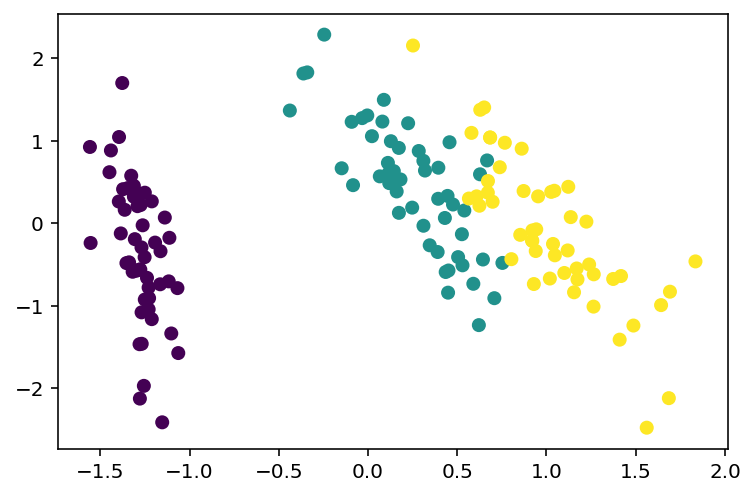

In [6]:
Mx = W.T @ W + sigma2 * np.identity(M)

Ez = inv(Mx) @ W.T @ (X - mu).T

plt.scatter(*Ez, c=y);

## PPCA and the EM algorithm

An alternate way to estimate the parameters of the probabilistic PCA model is via the EM algorithm by considering the latent variable ${\bf z}_n$.

For PPCA, the expected value of the complete data log-likelihood with respect to the posterior latent distribution $Q = \mathbb{E}\left[\log p\left({\bf X}, {\bf Z}|\boldsymbol\mu, {\bf W}, \sigma^2\right)\right]$ is given by

$$
\begin{align}
    Q &=-\sum_{n=1}^N\Big\{\frac{M}{2}\log 2\pi + \text{Tr}\left(\mathbb{E}[{\bf z}_n{\bf z}_n^T]\right) + \frac{D}{2} \log2\pi\sigma^2\\
    %% Second term
    & + \frac{1}{2\sigma^2}\vert\vert{\bf x}_n - \bar{\bf x}\vert\vert - \frac{1}{\sigma^2}\mathbb{E}[{\bf z}_n]^T{\bf W}^T({\bf x}_n - \bar{\bf x}) + \frac{1}{\sigma^2}\text{Tr}\left(\mathbb{E}[{\bf z}_n{\bf z}_n^T]{\bf W}^T{\bf W}\right)\Big\}
\end{align}
$$


Recalling that $p({\bf z} \vert {\bf x}) = \mathcal{N}\left({\bf z}\vert {\bf M}^{-1}{\bf W}^T({\bf x}_n - \bar{\bf x}), \sigma^{-1}{\bf M}\right)$; ${\bf M} = {\bf W}^T{\bf W} + \sigma^2{\bf I}$ we obtain the following updating statistics:

$$
    \mathbb{E}[{\bf z}_n] = {\bf M}^{-1}{\bf W}^T({\bf x}_n - \bar{\bf x})
$$

$$
    \mathbb{E}\left[{\bf z}_n{\bf z}_n^T\right] = \mathbb{E}[{\bf z}_n]\mathbb{E}[{\bf z}_n]^T + \sigma^{-2}{\bf M}^{-1}
$$

Next, taking the derivative of $Q$ w.r.t. $\sigma^2$ and $\bf W$ and noting that $\mu_{\text{ML}} = \bar{\bf x}$, we obtain the updating equations:

$$
    \sigma_{\text{new}} = \frac{1}{ND}\sum_{n=1}^N \left\{\vert\vert{\bf x}_n - \bar{\bf x}\vert\vert^2 - 2\mathbb{E}[{\bf z}_n]^T{\bf W}^T({\bf x}_n - \bar{\bf x}) + \text{Tr}\left(\mathbb{E}[{\bf z}_n{\bf z}_n^T]{\bf W}^T{\bf W}\right)\right\}
$$

$$
    {\bf W}_{\text{new}} = \left(\sum_{n=1}^N\left({\bf x}_n - \bar{\bf x}_n\right)\mathbb{E}[{\bf z}_n]^T\right)\left(\sum_{n=1}^N\mathbb{E}\left[{\bf z}_n{\bf z}_n^T\right]\right)^{-1}
$$

Thus, we obtain the following updating equations
* **E**-step: Compute the sufficient statistics $\mathbb{E}\left[{\bf z}_n\right]$ and $\mathbb{E}\left[{\bf z}_n{\bf z}_n^T\right]$ considering the values ${\bf W}_\text{old}$ and $\sigma^2_\text{old}$
* **M**-step: Update ${\bf W}_\text{old}$, $\sigma^2_\text{old}$

### MNIST Example

In [116]:
mnist = tf.keras.datasets.mnist.load_data()
(Xtrain, ytrain), (Xtest, ytest) = mnist

In [117]:
N, D, D = Xtrain.shape
X = Xtrain.reshape(N, -1)
N, D = X.shape

Xhat = X - X.mean(axis=0)

In [118]:
M = 2
W = np.random.randn(D, M)
sigma2 = 0.5

In [119]:
# Helper posterior distribution matrix
Mz = W.T @ W + sigma2 * np.identity(M)

In [120]:
%%time
## equivalent: E_zn = inv(Mz) @ W.T @ X.T
E_zn = np.einsum("ij,mj,km->ik", inv(Mz), W, Xhat, optimize=True)
E_znzn = np.einsum("in,kn->kin", E_zn, E_zn, optimize=True) + inv(Mz)[..., None] / sigma2

CPU times: user 125 ms, sys: 2.43 ms, total: 127 ms
Wall time: 31.8 ms


####  $\sigma_\text{new}^2$ components

$$
\sum_{n=1}^N \vert\vert{\bf x}_n - \bar{\bf x}\vert\vert^2
$$

In [121]:
%%time
Xnorm2 = (Xhat ** 2).sum()

CPU times: user 142 ms, sys: 110 ms, total: 252 ms
Wall time: 251 ms


$$
-2\sum_{n=1}^N \left\{\mathbb{E}[{\bf z}_n]^T{\bf W}^T({\bf x}_n - \bar{\bf x})\right\}
$$

In [122]:
%%time
T2 = - 2 * np.einsum("in,mi,nm->", E_zn, W, Xhat, optimize=True)

CPU times: user 168 ms, sys: 2.83 ms, total: 171 ms
Wall time: 42.6 ms


$$
\sum_{n=1}^N \left\{\text{Tr}\left(\mathbb{E}[{\bf z}_n{\bf z}_n^T]{\bf W}^T{\bf W}\right)\right\}
$$

In [123]:
%%time
T3 = np.einsum("ijn,mi,mj->", E_znzn, W, W, optimize="optimal")

CPU times: user 1.87 ms, sys: 711 µs, total: 2.58 ms
Wall time: 1.46 ms


In [124]:
sigma2_new = (Xnorm2 + T2 + T3) / (N * D)
sigma2_new

4362.2456036048425

---

#### ${\bf W}_\text{new}$ components

$$
\sum_{n=1}^N\left({\bf x}_n - \bar{\bf x}_n\right)\mathbb{E}[{\bf z}_n]^T
$$

In [125]:
%%time
T1 = np.einsum("nd,mn,jmn->dj", Xhat, E_zn, E_znzn, optimize="optimal")

CPU times: user 101 ms, sys: 1.97 ms, total: 103 ms
Wall time: 26.9 ms


$$
\sum_{n=1}^N\mathbb{E}\left[{\bf z}_n{\bf z}_n^T\right]
$$

In [126]:
%%time
T2 = E_znzn.sum(axis=-1)

CPU times: user 1.87 ms, sys: 702 µs, total: 2.57 ms
Wall time: 1.46 ms


In [127]:
W_new = (T1 @ inv(T2))

### All together

In [405]:
class ProbabilisticPCA:
    """
    Implementation of the Probabilistic PCA (PPCA) algorithm
    in which we assume that a datapoint in drawn from a latent
    variable z R^M, shifted via a parameter mu, and then projected
    onto R^D via the projecting matrix W plus some additive noise
    sigma2. Hence
    
        x = Wz + mu + eps; eps ~ N(0, sigma2)
        
    """
    def __init__(self, X, M, W_init=None, sigma2_init=None, seed=None):
        self.seed = seed
        self.M = M
        self.N, self.D = X.shape
        self.Xbar = X - X.mean(axis=0)
        self.Xnorm2 = (self.Xbar ** 2).sum()
        self.W = self._initialize_W(W_init)
        self.sigma2 = self._initialize_sigma2(sigma2_init)
        self.E_zn, self.E_znzn = self._compute_expectations()
        
    
    def _initialize_W(self, W_init):
        np.random.seed(self.seed)
        if W_init is None:
            return np.random.randn(self.D, self.M)
        else:
            return W_init
        
        
    def _initialize_sigma2(self, sigma2_init):
        np.random.seed(self.seed)
        if sigma2_init is None:
            return np.random.rand()
        else:
            return sigma2_init
        
        
    def _compute_expectations(self):
        """
        :::E-Step:::

        Compute ∀n in the dataset. E[zn], E[zn@zn.T]
        """
        Mz = self.W.T @ self.W + self.sigma2 * np.identity(self.M)
        i_Mz = inv(Mz)
        
        E_zn = np.einsum("ij,mj,km->ik", i_Mz, self.W, self.Xbar, optimize=True)
        E_znzn = np.einsum("in,kn->kin", E_zn, E_zn, optimize=True) + i_Mz[..., None] / self.sigma2
        
        return E_zn, E_znzn
    
    
    def update_sigma2(self):
        T2 = - 2 * np.einsum("in,mi,nm->", self.E_zn, self.W, self.Xbar, optimize=True)
        T3 = np.einsum("ijn,mi,mj->", self.E_znzn, self.W, self.W, optimize="optimal")
        sigma2_new = (self.Xnorm2 + T2 + T3) / (self.N * self.D)
        
        return sigma2_new
    
    
    def update_W(self):
        T1 = np.einsum("nd,mn,jmn->dj", self.Xbar,
                       self.E_zn, self.E_znzn, optimize="optimal")
        T2 = self.E_znzn.sum(axis=-1)
        
        W_new = (T1 @ inv(T2))
        
        return W_new
    
    
    def _update_parameters(self):
        """
        :::M-step:::
        
        Compute one step of the EM-algorithm
        (assuming that the E-step has already been)
        computed
        """
        sigma2_new = self.update_sigma2()
        W_new = self.update_W()
        
        return sigma2_new, W_new
        
        
    def data_log_likelihood(self):
        """
        Compute the expected value of the complete-data log-likelihood
        with respect to the posterior distribution of the latent
        variable
        """
        Q = -(self.N * self.M * np.log(2 * np.pi) / 2 +
              np.einsum("iin->", self.E_znzn) + 
              D * np.log(2 * np.pi * self.sigma2) / 2 +
              self.Xnorm2 / (2 *  self.sigma2) +
              -np.einsum("in,mi,nm->", self.E_zn, self.W, self.Xbar, optimize=True) / (self.sigma2) + 
              np.einsum("ijn,mi,mj->", self.E_znzn, self.W, self.W, optimize="optimal") / (self.sigma2)
              )
        
        return Q
    
    def project(self):
        Mz = self.W.T @ self.W + self.sigma2 * np.identity(self.M)
        Xproj = inv(Mz) @ self.W.T @ self.Xbar.T
        return Xproj
    
    def EM_step(self):
        # E-step
        self.E_zn, self.E_znzn = self._compute_expectations()
        # M-step
        self.sigma2, self.W = self._update_parameters()
        
        Q = self.data_log_likelihood()
        return Q

$$
\begin{align}
    Q &=-\sum_{n=1}^N\Big\{\frac{M}{2}\log 2\pi + \text{Tr}\left(\mathbb{E}[{\bf z}_n{\bf z}_n^T]\right) + \frac{D}{2} \log2\pi\sigma^2\\
    %% Second term
    & + \frac{1}{2\sigma^2}\vert\vert{\bf x}_n - \bar{\bf x}\vert\vert - \frac{1}{\sigma^2}\mathbb{E}[{\bf z}_n]^T{\bf W}^T({\bf x}_n - \bar{\bf x}) + \frac{1}{\sigma^2}\text{Tr}\left(\mathbb{E}[{\bf z}_n{\bf z}_n^T]{\bf W}^T{\bf W}\right)\Big\}
\end{align}
$$



In [439]:
M = 2
ppca = ProbabilisticPCA(X, M, sigma2_init=100, seed=2718)

nits = 50
Qhist = [-np.inf]
list_projections = []
for n in range(nits):
    Q = ppca.EM_step()
    *_, Qlast = Qhist
    Qhist.append(Q)
    
    if (Q / Qlast < 1e-2) and not np.isinf(Qlast):
        break
    list_projections.append(ppca.project())

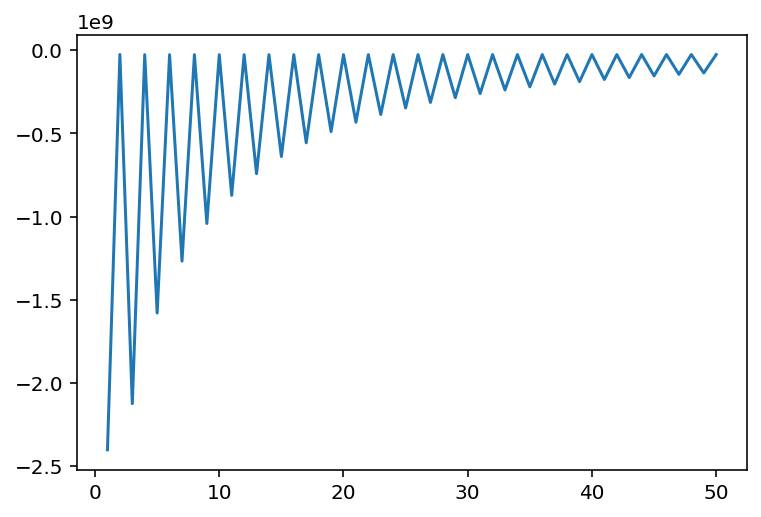

In [440]:
plt.plot(Qhist)

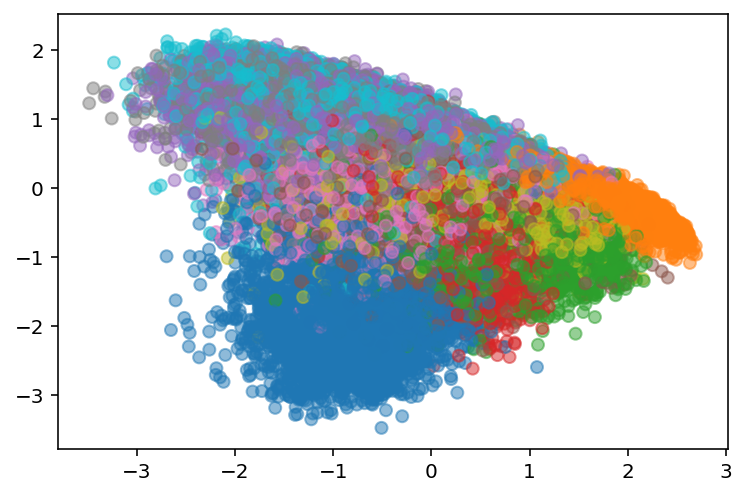

In [441]:
plt.scatter(*ppca.project(), c=ytrain, cmap="tab10", alpha=0.5)

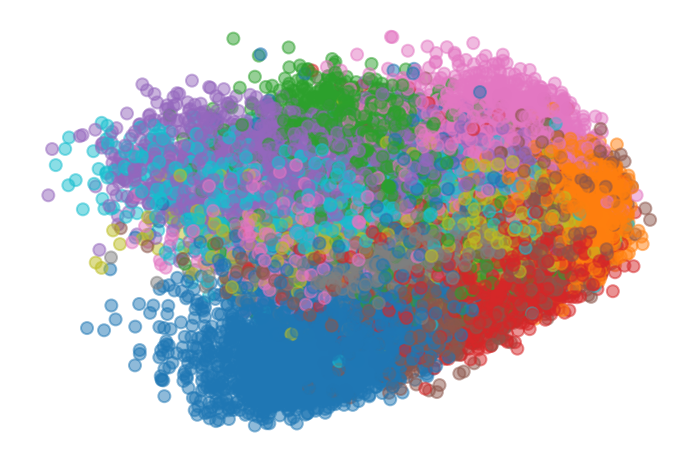

In [443]:
import matplotlib.animation as animation

fig, ax = plt.subplots()
def func(i):
    plt.cla()
    projection = list_projections[i]
    ax.scatter(*projection, c=ytrain, cmap="tab10", alpha=0.5)
    plt.axis("off")

ani = animation.FuncAnimation(fig, func, frames=10)
ani.save("/Users/gerardoduran/Desktop/ppca2.gif", writer="imagemagick")